# Overview
- Written for simulating double indexing (barcoded FIP and barcoded BIP)
- Plug in parameters in parameter box, can run simulations immediately
- Script meant to calculate error rates given template switching, sample skewing, and barcode loss in a generalizable way
    - Barcode loss modeled in a lossy discrete encoder
    - Barcode loss and sample skewing modeled in a lossy continuous encoder
    - Template switching modeled in a channel between encoder and decoder
- Have the option to run in a parallelized manner, for faster simulations

# To Do
- Make template switching dependent on centrality/degree of each barcode for discrete encoder
- Implement possibility for some people to have extra barcodes/less than expected due to liquid handling error
- Build a heatmap for FNPs/FPPs dependent on parameters for distribution of post-PCR molecules (mean, std)
- Characterize real transformations for module 1 (experimentally)

In [20]:
#Check for/install dependencies, may need to restart kernel after
%pip install --user tqdm
%pip install --user multiprocess

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [21]:
#Import useful general  libraries
import numpy as np
import math
import random
from random import seed
from random import randint
from tqdm.notebook import tnrange,tqdm_notebook, tqdm

#Packages for data analysis/stats
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score, confusion_matrix

#Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [22]:
#Import optional packages for parallelization:
from multiprocess import Pool
import psutil
from functools import partial

# Approach
## Modularization
Break into many transformations:
- Module 1: Patient samples viral load -> RT-LAMP molecules
- Module 2: RT-LAMP Molecules -> PCR molecules
- Module 3: PCR molecules are pooled into sequencer -> Sequencing reads -> Thresholded to produce binary output
- Module 4: Binary output (0 or 1 for each barcode) -> Decoder produces inferred patient truth. 

In [5]:
#Parameters

#Barcoding Parameters
scenario = 5 #Corresponding scenario - 3, 4, or 5. Details in text
m1 = 96 #Number of barcode 1s (FIP barcodes)
m2 = 96 #Number of barcode 2s (BIP barcodes)
m3 = 10 #Number of barcode 3s (well barcodes)
k1 = 3 #Number of barcode 1s per patient sample, scenario 4 and 5
k2 = 3 #Number of barcode 2s per patient sample, scenario 5
EnforceUnique = True #Enforces k1/k2 different barcodes per sample (Bloom filter calculations do not enforce)

#Decoder Parameters
scheme = 3 #Decoder scheme used, either 1, 2, or 3
k1prime = 2 #Number of positive barcode 1s required to call a barcode 2 positive, scheme 2
k2prime = 2 #Number of positive barcode 2s required to call sample positive, scheme 2
k12prime = 6 #Number of positive barcode 1 - barcode 2 pairs required to call sample positive, scheme 3

#General Parameters 
prob = 0.01 #Proportion of population infected
b = 100000 #Number of patient samples per batch
b2 = int(b/m3) #Number of patient samples per subbatch (with a rounding error)
n = int(np.ceil(b2*prob)) #Number of positive samples per subbatch (with a rounding error)
encoderchoice = 0 #Which encoder to use - 0 is discretelossy, 1 is continuouslossy
iters = 1000 #Number of iterations to run things
parallelized = True #Parallelized (True) or non-parallized computation (False)

#Parameters for barcode loss and template switching errors
dsynth = 0.00 #Proportion of barcode 1 and 2s that always fail
dstoch = 0.05 #Proportion of stochastic barcode 1-2 pair failure
dswitch = 0.02 #Refer to module 2 details

#Parameters for sample skewing (continuouslossyencoder)
setting = "Sat" #Either "Amp" or "Sat" describing models Amplified and Saturated respectively
ampmean = 4.5 #Mean of log-normal distribution of molecules
ampstd = 3 #Standard deviation of log-normal distribution of molecules
satmean = 10000 #Mean of normal distribution of molecules
satstd = 1000 #Standard deviation of distribution of molecules

#Parameters for read thresholding (continuouslossyencoder)
totalreads = 2*(10**8) #Reads per Illumina run
readspersubbatch = totalreads/m3 #Reads per subbatch
propnoise = 0.1 #Proportion of reads that are junk
goodreads = int(np.ceil((1-propnoise)*readspersubbatch)) #Number of good reads per subbatch (with a rounding error)
threshold = 100 #Reads required to call a sample positive

## Module 1

### Input:
- For discrete encoder, this is 1 for positive patients, 0 for negative patients
- For continuous encoder, positive patient samples are assumed to follow some distribution of viral load, 0 if negative
    - The exact distribution here is uncharacterized, and is currently lumped into the post-PCR distribution
        - So for now, this step relies on predicted post-PCR distribution
        - Specific details in module 2 description, see below 
    - This can be drawn from a MC-MC model later if we have a better model of the transformation through PCR
    
### Transformation:
- D<sub>stoch</sub> and D<sub>synth</sub> errors are incorporated here
    - D<sub>stoch</sub> is stochastic dropout frequency for any barcode pair 
    - D<sub>synth</sub> is a systematic error frequency for a barcode to consistently fail
- Each patient sample gets k1 of the m1 possible barcode 1s and k2 of the m2 possible barcode 2s
- For discrete encoder, the k1 x k2 corresponding barcode pairs are set positive (0 -> 1)
- For continuous encoder, the k1 x k2 corresponding barcode pairs are set positive with initial copy number for each

### Output: 
- For both the continuous and discrete encoder, this outputs a matrix (m1 x m2) of counts for each barcode pair

In [6]:
def discretelossyencoder(truth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    Includes error where some barcodes always fail and some barcodes stochastically fail
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m1 - number of barcode 1s
        k1 - number of barcode 1s per patient sample
        m2 - number of barcode 2s
        k2 - number of barcode 2s per patient sample
        EnforceUnique - Boolean for whether to enforce unique barcodes
        scenario - either 3, 4, or 5. Describes which scenario chosen
        dsynth - proportion of barcode 1s and barcode 2s that always fail
        dstoch - proportion of stochastic barcode 1 - barcode 2 pair failure
    
    Outputs:
        barcodes - array (m1 x m2), 0 if negative, 1 if positive
    '''
    #Initialize barcode matrix
    barcodes = np.zeros((m1, m2)).astype(int)
    
    #Iterate through samples in truth and set corresponding barcodes to 1, accounting for dstoch
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #Generate barcodes for all scenarios
            if k1 > m1 or k2 > m2: #Check that k1 and k2 values are okay
                raise ValueError("Barcodes per sample exceed number of unique samples")
            seed(samp) #Set seed to RNG as sample index
            sampleBC1s = []
            sampleBC2s = []
            if EnforceUnique:
                while len(sampleBC1s) < k1:
                    randomBC1 = randint(0, m1-1)
                    if randomBC1 not in sampleBC1s:
                        sampleBC1s.append(randomBC1)
                while len(sampleBC2s) < k2:
                    randomBC2 = randint(0, m2-1)
                    if randomBC2 not in sampleBC2s:
                        sampleBC2s.append(randomBC2)
            else:
                for BC1 in range(k1):
                    sampleBC1s.append(randint(0, m1-1))
                for BC2 in range(k2):
                    sampleBC2s.append(randint(0, m2-1))
                    
            #Select scenario specific barcodes 
            if scenario == 3:
                if m1*m2 < truth2: #Check that there are enough unique barcode pairs
                    raise ValueError("Not enough barcode pairs to uniquely barcode")
                BC1indices = [samp%m1]
                BC2indices = [int(np.floor(samp/m1))]
            elif scenario == 4:
                BC1indices = sampleBC1s
                BC2indices = [sampleBC2s[0]]
            elif scenario == 5:
                BC1indices = sampleBC1s
                BC2indices = sampleBC2s
            else:
                raise ValueError("Scenario chosen not valid")
                
            #Set corresponding barcodes to 1
            for BC1index in BC1indices:
                for BC2index in BC2indices:
                    randomprob = random.random()
                    if randomprob >= dstoch: #Fails dstoch proportion of the time
                        barcodes[BC1index, BC2index]=1 #Set barcode to 1
            
    #Now, we deal with dsynth
    numBC1zeros = int(np.ceil(m1*dsynth)) #Calculate number of barcode 1s that always fail (with a rounding error)
    BC1_index_list = [] #Generate indices that should be 0
    while len(BC1_index_list) < numBC1zeros:
        random_BC1_index = randint(0, m1-1)
        if random_BC1_index not in BC1_index_list:
            BC1_index_list.append(random_BC1_index)
    for position in BC1_index_list: #Set those indices to 0
        barcodes[position,:] = 0
         
    numBC2zeros = int(np.ceil(m2*dsynth)) #Calculate number of barcode 2s that always fail (with a rounding error)
    BC2_index_list = [] #Generate indices that should be 0
    while len(BC2_index_list) < numBC2zeros:
        random_BC2_index = randint(0, m2-1)
        if random_BC2_index not in BC2_index_list:
            BC2_index_list.append(random_BC2_index)
    for position in BC2_index_list: #Set those indices to 0
        barcodes[:, position] = 0
        
    #Return final vector
    return barcodes

In [7]:
def continuouslossyencoder(truth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of barcode reads
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    Includes error where some barcodes always fail and some barcodes stochastically fail
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m1 - number of barcode 1s
        k1 - number of barcode 1s per patient sample
        m2 - number of barcode 2s
        k2 - number of barcode 2s per patient sample
        EnforceUnique - Boolean for whether to enforce unique barcodes
        scenario - either 3, 4, or 5. Describes which scenario chosen
        dsynth - proportion of barcode 1s and barcode 2s that always fail
        dstoch - proportion of stochastic barcode 1 - barcode 2 pair failure
        setting - either "Amp" or "Sat" describing models Amplified and Saturated respectively
        ampmean - mean of log-normal distribution of molecules
        ampstd - standard deviation of log-normal distribution of molecules
        satmean - mean of normal distribution of molecules
        satstd - standard deviation of distribution of molecules
    
    Outputs:
        barcodes - array (m1 x m2), contains reads per barcode
    '''
    #Initialize barcode matrix
    barcodes = np.zeros((m1, m2))
    
    #Iterate through samples in truth and set corresponding barcode reads
    #Accounts for dstoch, and sample skewing
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #Generate barcodes for all scenarios
            if k1 > m1 or k2 > m2: #Check that k1 and k2 values are okay
                raise ValueError("Barcodes per sample exceed number of unique samples")
            seed(samp) #Set seed to RNG as sample index
            sampleBC1s = []
            sampleBC2s = []
            if EnforceUnique:
                while len(sampleBC1s) < k1:
                    randomBC1 = randint(0, m1-1)
                    if randomBC1 not in sampleBC1s:
                        sampleBC1s.append(randomBC1)
                while len(sampleBC2s) < k2:
                    randomBC2 = randint(0, m2-1)
                    if randomBC2 not in sampleBC2s:
                        sampleBC2s.append(randomBC2)
            else:
                for BC1 in range(k1):
                    sampleBC1s.append(randint(0, m1-1))
                for BC2 in range(k2):
                    sampleBC2s.append(randint(0, m2-1))
                    
            #Select scenario specific barcodes 
            if scenario == 3:
                if m1*m2 < truth2: #Check that there are enough unique barcode pairs
                    raise ValueError("Not enough barcode pairs to uniquely barcode")
                BC1indices = [samp%m1]
                BC2indices = [int(np.floor(samp/m1))]
            elif scenario == 4:
                BC1indices = sampleBC1s
                BC2indices = [sampleBC2s[0]]
            elif scenario == 5:
                BC1indices = sampleBC1s
                BC2indices = sampleBC2s
            else:
                raise ValueError("Scenario chosen not valid")
            
            #Calculate moleculenumber
            if setting == "Amp":
                moleculenumber=np.random.lognormal(ampmean, ampstd, size=None)
            elif setting == "Sat":
                moleculenumber=np.random.normal(satmean, satstd, size=None)
            else:
                raise ValueError("Setting chosen not valid")
                
            #Add moleculenumber to corresponding barcodes
            for BC1index in BC1indices:
                for BC2index in BC2indices:
                    randomprob = random.random()
                    if randomprob >= dstoch: #Fails dstoch proportion of the time
                        barcodes[BC1index, BC2index] += moleculenumber #Set barcode to moleculenumber
            
    #Now, we deal with dsynth
    numBC1zeros = int(np.ceil(m1*dsynth)) #Calculate number of barcode 1s that always fail (with a rounding error)
    BC1_index_list = [] #Generate indices that should be 0
    while len(BC1_index_list) < numBC1zeros:
        random_BC1_index = randint(0, m1-1)
        if random_BC1_index not in BC1_index_list:
            BC1_index_list.append(random_BC1_index)
    for position in BC1_index_list: #Set those indices to 0
        barcodes[position,:] = 0
         
    numBC2zeros = int(np.ceil(m2*dsynth)) #Calculate number of barcode 2s that always fail (with a rounding error)
    BC2_index_list = [] #Generate indices that should be 0
    while len(BC2_index_list) < numBC2zeros:
        random_BC2_index = randint(0, m2-1)
        if random_BC2_index not in BC2_index_list:
            BC2_index_list.append(random_BC2_index)
    for position in BC2_index_list: #Set those indices to 0
        barcodes[:, position] = 0
        
    #Return final vector
    return barcodes

## Module 2 Model

### Transformation: 
- Template switching (D<sub>switch</sub>) errors are incorporated here
    - D<sub>switch</sub> is frequency a specific barcode 1-barcode 2 pair will be generated if barcode 1 and barcode 2 are both in the pool of positive RT-lamp samples
    - For discrete, this manifests as barcode pair probability = Dswitch x ((barcode 1 in pool) AND (barcode 2 in pool))
    - For continuous, proportion of all reads due to template switching varies by number of reads.
        - Probabilty of a given pair to switch is dswitch * 4* sigmoid(log relative abundance BC1) * sigmoid(log relative abundance BC2)
        - This allows up to a 4-fold increase in template switching, and reduces the probability for barcodes of low abundance
        - Template switching reads added are average of mean # of barcode 1 and mean # of barcode 2
- For the continuous encoder, molecule distributions post-PCR are assumed to either have an amplification function that linearly amplifies initial viral loads or saturates, which normalizes initial viral titer loads
    - for linearly amplified viral titer loads, molecules follow a log normal distribution with mean = 4.5, std = 3
    - for saturating amplification functions, molecules follow a normal distribution with mean 10000, std 1000
    - this is currently lumped into module 1 function
- For the discrete encoder, nothing changes except for the incorporation of template switching errors

### Output: 
- Matrix (m1 x m2) of counts for each barcode pair

In [8]:
def module2discreteencoder(barcodes, dswitch):
    '''
    Function takes array of which barcodes are pos/neg and returns array off barcodes including template switching
    
    Inputs:
        barcodes - array (m1 x m2), matrix of positive (1)/negative (0) barcodes
        dswitch - probability of template switching as outlined above
    
    Outputs:
        apparentbarcodes - array (m1 x m2), matrix of positive (1)/negative (0) barcodes
    '''
    #Initialize array
    apparentbarcodes = barcodes.copy()
    
    #Compute barcodes in positive PCR pool
    positiveBC1s = np.max(apparentbarcodes, axis=1)
    positiveBC1indices = np.where(positiveBC1s == 1)[0]

    positiveBC2s = np.max(apparentbarcodes, axis=0)
    positiveBC2indices = np.where(positiveBC2s == 1)[0]
    
    #Flip edge to positive with probability dswitch
    for BC1index in positiveBC1indices:
        for BC2index in positiveBC2indices:
            if apparentbarcodes[BC1index, BC2index] != 1:
                randomprob = random.random()
                if randomprob <= dswitch: #Flips dswitch proportion of the time
                        apparentbarcodes[BC1index, BC2index] = 1 #Set barcode to 1

    #Return final array                                
    return apparentbarcodes

In [9]:
#Helper function for sigmoid
def sigmoid(x):
      return 1 / (1 + math.exp(-x))
    
def module2continuousencoder(barcodes, dswitch):
    '''
    Function takes np array of counts for each barocde and returns array of counts including template switching
    
    Inputs:
        barcodes - array (m1 x m2), contains reads per barcode
        dswitch - probability of template switching as outlined above
    
    Outputs:
        apparentbarcodes - array (m1 x m2), contains reads per barcode
    '''
    #Initialize array
    (m1, m2) = barcodes.shape
    apparentbarcodes = barcodes.copy()
    
    #Compute barcodes in positive PCR pool
    positiveBC1s = np.sum(barcodes, axis=1)
    positiveBC1indices = np.where(positiveBC1s > 0)[0]

    positiveBC2s = np.sum(barcodes, axis=0)
    positiveBC2indices = np.where(positiveBC2s > 0)[0]
    
    #Add reads to template switching edges
    for BC1index in positiveBC1indices:
        for BC2index in positiveBC2indices:
            #Compute propensity/threshold probability for template switching
            BC1propensity = 2*sigmoid(np.log(positiveBC1s[BC1index]/np.mean(positiveBC1s[positiveBC1s!=0]))/2) #Uses relative abundance compared to average                  
            BC2propensity = 2*sigmoid(np.log(positiveBC2s[BC2index]/np.mean(positiveBC2s[positiveBC1s!=0]))/2) #Uses relative abundance compared to average
            thresholdprob = dswitch*BC1propensity*BC2propensity
            
            #If RNG < thresholdprob, add molecules that are average for barcodes
            randomprob = random.random()
            if randomprob <= thresholdprob: #Flips thresholdprob proportion of the time
                apparentbarcodes[BC1index, BC2index] += (positiveBC1s[BC1index]/m1+positiveBC2s[BC2index]/m2)/2
    
    #Return final array                                
    return apparentbarcodes

## Module 3 Model
### Transformation:
- For discrete, nothing happens
- For continuous, fractional abundance for each barcode pair is computed
    - Calculated by dividing count by total number of molecules for a subbatch 
- If fractional abundance for a barcode * total good reads per subbatch > threshold, 1. Otherwise, 0. 

### Output:
- Matrix (m1 x m2) of 1 or 0 for each barcode pair

In [10]:
def module3discreteencoder(apparentbarcodes):
    '''
    Nothing happens in module3 for the discreteencoder
    '''  
    return apparentbarcodes

In [11]:
def module3continuousencoder(apparentbarcodes, goodreads, threshold):
    '''
    Function takes np array of barcode reads and returns np array of which barcodes are pos/neg
    
    Inputs:
        apparentbarcodes - array (m1 x m2), contains reads per barcode pair
        goodreads - number of good reads per subbatch (with a rounding error)
        threshold - reads needed to call something positive
    
    Outputs:
        thresholdedbarcodes - array (m1 x m2), 0 if negative, 1 if positive
    '''
    #Model for sequencer (barcode reads = relative abundance of barcode * total good reads)
    barcodereads = apparentbarcodes/np.sum(apparentbarcodes)*goodreads
    
    #Threshold and set to 0 or 1
    thresholdedbarcodes = np.where(barcodereads > threshold, 1, 0).astype(int)
    
    #Return final vector
    return thresholdedbarcodes

## Module 4 Model
### Transformation:
 - 3 possible schemes are used for the decoder
     - Scheme 1: All k1 x k2 barcode pairs need to be positive
     - Scheme 2: At least k2' out of k2 BC2 have at least k1' out of k1 barcode pairs
     - Scheme 3: At least k12' out of k1 x k2 barcode pairs positive
     
### Output:
- Vector of the inferred truth for each patient (0 for negative, 1 for positive)
- Helper function inferenceanalysis calculates FPP and FNP from ground and inferred truth

In [12]:
def decoder(apparentbarcodes, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario):
    '''
    Function takes np array of which barcodes are pos/neg and returns np array of which patient samples seem pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        apparentbarcodes - array (m1 x m2), matrix of positive (1)/negative (0) barcodes
        b2 - number of patient samples per subbatch
        k1 - number of barcode 1s per patient sample
        k2 - number of barcode 2s per patient sample
        EnforceUnique - Boolean for whether to enforce unique barcodes
        scheme - decoder scheme used, either 1, 2, or 3
        k1prime - number of positive barcode 1s required to call a barcode 2 positive, scheme 2
        k2prime - number of positive barcode 2s required to call sample positive, scheme 2
        k12prime - Number of positive barcode 1 - barcode 2 pairs required to call sample positive, scheme 3
        scenario - either 3, 4, or 5, describes which scenario chosen
    
    Outputs:
        inferredtruth - array (1 x b2), 0 if negative, 1 if positive, decoded patient samples
    '''
    #Initialize final inferred patient truth matrix
    inferredtruth = np.zeros((1, b2)).astype(int)
    
    #Calculate m1, m2 and run some sanity checks
    (m1, m2) = apparentbarcodes.shape
    if scenario not in [3, 4, 5]:
        raise ValueError("Scenario chosen not valid")
    if k1 > m1 or k2 > m2: #Check that k1 and k2 values are okay
        raise ValueError("Barcodes per sample exceed number of unique samples")
    if k1prime > k1 or k2prime > k2:
        raise ValueError("k1prime or k2prime is out of range")
    if k12prime > k1*k2:
        raise ValueError("k12prime is out of range")
    if (scenario == 3 and scheme != 1) or (scenario == 4 and scheme == 2):
        raise ValueError("Decoder scheme not valid for current scenario")
    
    #Iterate through samples in truth, setting to 1 if decoder scheme is satisfied
    for samp in range(b2):
        if scenario == 3: #Deals with scenario 3 - unique pair per patient
            if m1*m2 < b2: #Check that there are enough unique barcode pairs
                raise ValueError("Not enough barcode pairs to uniquely barcode")
            if apparentbarcodes[samp%m1, int(np.floor(samp/m1))] == 1:
                inferredtruth[0, samp] = 1
        
        else: #Scenarios 4 and 5
            #Generate sample barcodes
            seed(samp) #Set seed to RNG as sample index
            sampleBC1s = []
            sampleBC2s = []
            if EnforceUnique:
                while len(sampleBC1s) < k1:
                    randomBC1 = randint(0, m1-1)
                    if randomBC1 not in sampleBC1s:
                        sampleBC1s.append(randomBC1)
                while len(sampleBC2s) < k2:
                    randomBC2 = randint(0, m2-1)
                    if randomBC2 not in sampleBC2s:
                        sampleBC2s.append(randomBC2)
            else:
                for BC1 in range(k1):
                    sampleBC1s.append(randint(0, m1-1))
                for BC2 in range(k2):
                    sampleBC2s.append(randint(0, m2-1))
            if scenario == 4:
                sampleBC2s = [sampleBC2s[0]]
                k2 = 1
                                
            #Check corresponding barcode pairs and propagate induced subgraph matrix
            samplebarcodevalues = np.zeros((k1, k2)).astype(int)
            for BC1num in range(k1):
                for BC2num in range(k2):
                    samplebarcodevalues[BC1num, BC2num] = apparentbarcodes[sampleBC1s[BC1num], sampleBC2s[BC2num]]
                    
            #Check criteria for chosen decoder scheme
            if scheme == 1 and np.sum(samplebarcodevalues)==k1*k2:
                inferredtruth[0, samp] = 1
            if scheme == 2 and len(np.where(np.sum(samplebarcodevalues, axis = 0)>=k1prime)[0]) >= k2prime:
                inferredtruth[0, samp] = 1 
            if scheme == 3 and np.sum(samplebarcodevalues)>=k12prime:
                inferredtruth[0, samp] = 1 
    
    #Return final array
    return inferredtruth

In [13]:
def inferenceanalysis(groundtruth, inferredtruth):
    '''
    Function takes np array of which patient samples truely are pos/neg and are inferred to be pos/neg
    Returns false negative and positive probabilities
    
    Inputs:
        groundtruth - array (1 x b2), 0 if negative, 1 if positive, true patient samples
        inferredtruth - array (1 x b2), 0 if negative, 1 if positive, decoded patient samples
        
    Outputs:
        [FPP, FNP] - false positive probability, false negative probability 
    '''
    [tn, fp, fn, tp] = confusion_matrix(groundtruth[0], inferredtruth[0]).ravel()
    return [fp/(tn+fp), fn/(fn+tp)]

## Main Functions

In [14]:
#Main function for simulations of discrete encoder
def calculateerrors(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime):
    #Initialize arrays for storing things
    FPPs = []
    FNPs = []
    dropout = []
    templateadded = []
    netchange = []

    for iterations in tqdm_notebook(range(iters), desc='Iterations complete', leave=None):
        #Initialize arrays to represent ground truth
        initarray = np.array([0] * (b2-n) + [1] * (n))
        np.random.shuffle(initarray)
        groundtruth = np.array([initarray])

        #Encode groundtruth into barcode vectors (module 1)
        barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
        barcodes = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch)
        
        #Add template switching (module 2)
        apparentbarcodes = module2discreteencoder(barcodes, dswitch)
        
        #Module 3 does nothing, so skipped
        #Decode barcode vector to recover inferred truth (module 4)
        inferredtruth = decoder(apparentbarcodes, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)

        #Compare inferred versus ground truth and store relevant parameters
        [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
        dropout.append(np.sum(barcodetruth-barcodes))
        templateadded.append(np.sum(apparentbarcodes-barcodes))
        netchange.append(np.sum(apparentbarcodes-barcodetruth))
        FPPs.append(FPP)
        FNPs.append(FNP)
        
    #Return final arrays
    return [dropout, templateadded, netchange, FPPs, FNPs]

In [100]:
#Main function for simulations of continuous encoder
def calculateerrorscontinuous(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime):
    #Initialize arrays for storing things
    FPPs = []
    FNPs = []
    dropout = []
    templateadded = []
    netchange = []

    for iterations in tqdm_notebook(range(iters), desc='Iterations complete', leave=None):
        #Initialize arrays to represent ground truth
        initarray = np.array([0] * (b2-n) + [1] * (n))
        np.random.shuffle(initarray)
        groundtruth = np.array([initarray])

        #Encode groundtruth into barcode vectors (module 1)
        barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
        barcodes = continuouslossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd)
        
        #Add template switching (module 2)
        apparentbarcodes = module2continuousencoder(barcodes, dswitch)

        #Threshold using sequencing parameters (module 3)
        barcodesthresholded = module3continuousencoder(apparentbarcodes, goodreads, threshold)
        
        #Decode barcode vector to recover inferred truth (module 4)
        inferredtruth = decoder(barcodesthresholded, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)
    
        #Compare inferred versus ground truth and store relevant parameters
        [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
        barcodes = np.where(barcodes > 0, 1, 0).astype(int) #Discretize for barcode counting
        dropout.append(np.sum(barcodetruth-barcodes))
        templateadded.append(np.sum(barcodesthresholded-barcodes))
        netchange.append(np.sum(barcodesthresholded-barcodetruth))
        FPPs.append(FPP)
        FNPs.append(FNP)
        
    #Return final arrays
    return [dropout, templateadded, netchange, FPPs, FNPs]

In [101]:
#Parallelized Version of Main Functions

#Helper function for calculating errors of single iteration
def singleitererrors(b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime, x):
    #Initialize arrays to represent ground truth
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])

    #Encode groundtruth into barcode vectors (module 1)
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch)

    #Add template switching (module 2)
    apparentbarcodes = module2discreteencoder(barcodes, dswitch)
    
    #Module 3 does nothing, so skipped
    #Decode barcode vector to recover inferred truth (module 4)
    inferredtruth = decoder(apparentbarcodes, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)

    #Compare inferred versus ground truth and store relevant parameters
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
    dropoutnumber = np.sum(barcodetruth-barcodes)
    templateaddednumber = np.sum(apparentbarcodes-barcodes)
    netchangenumber = np.sum(apparentbarcodes-barcodetruth)
   
    #Return values
    return [dropoutnumber, templateaddednumber, netchangenumber, FPP, FNP]

#Main function (discrete)
def calculateerrorsparallel(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime):
    #Start pool
    pool = Pool(psutil.cpu_count(logical=False))
    
    #Iterate
    outputtransposed = list(tqdm_notebook(pool.imap_unordered(partial(singleitererrors, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime), range(iters)), total=iters, desc='Iterations complete', leave=None))
    
    #Close pool
    pool.close()
    
    #Return final arrays
    return np.array(list(outputtransposed)).T

#Helper function for calculating errors of single iteration - continuous
def singleitererrorscontinuous(b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime, x):
    #Initialize arrays to represent ground truth
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])

    #Encode groundtruth into barcode vectors (module 1)
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = continuouslossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd)

    #Add template switching (module 2)
    apparentbarcodes = module2continuousencoder(barcodes, dswitch)

    #Threshold using sequencing parameters (module 3)
    barcodesthresholded = module3continuousencoder(apparentbarcodes, goodreads, threshold)

    #Decode barcode vector to recover inferred truth (module 4)
    inferredtruth = decoder(barcodesthresholded, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)

    
    #Compare inferred versus ground truth and store relevant parameters
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
    barcodes = np.where(barcodes > 0, 1, 0).astype(int) #Discretize for barcode counting
    dropoutnumber = np.sum(barcodetruth-barcodes)
    templateaddednumber = np.sum(barcodesthresholded-barcodes)
    netchangenumber = np.sum(barcodesthresholded-barcodetruth)
    
    #Return values
    return [dropoutnumber, templateaddednumber, netchangenumber, FPP, FNP]

#Main function (continuous)
def calculateerrorsparallelcontinuous(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime):
    #Start pool
    pool = Pool(psutil.cpu_count(logical=False))
    
    #Iterate
    outputtransposed = list(tqdm_notebook(pool.imap_unordered(partial(singleitererrorscontinuous, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime), range(iters)), total=iters, desc='Iterations complete', leave=None))
    
    #Close pool
    pool.close()
    
    #Return final arrays
    return np.array(list(outputtransposed)).T

# Simulation with Parameters Chosen Above

In [16]:
if parallelized:
    if encoderchoice == 0:
        simulation = calculateerrorsparallel(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime)
    elif encoderchoice == 1:
        simulation = calculateerrorsparallelcontinuous(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime)
    else:
        raise ValueError("encoderchoice not valid")
else:
    if encoderchoice == 0:
        simulation = calculateerrors(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, dswitch, scheme, k1prime, k2prime, k12prime)
    elif encoderchoice == 1:
        simulation = calculateerrorscontinuous(iters, b2, n, m1, m2, k1, k2, EnforceUnique, scenario, dsynth, dstoch, setting, ampmean, ampstd, satmean, satstd, dswitch, goodreads, threshold, scheme, k1prime, k2prime, k12prime)
    else:
        raise ValueError("encoderchoice not valid")
       
[dropout, templateadded, netchange, FPPs, FNPs] = simulation

Average number of barcodes lost: 41.324


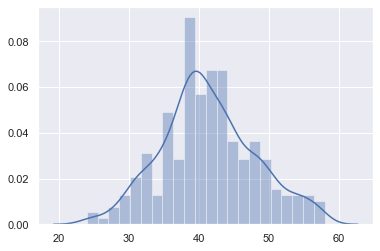

In [17]:
#Plot number of barcodes that go from 1 to 0 due to barcode loss
sns.distplot(dropout)
print("Average number of barcodes lost:", np.mean(dropout))

Average number of barcodes gained from template switching and thresholding: 153.8


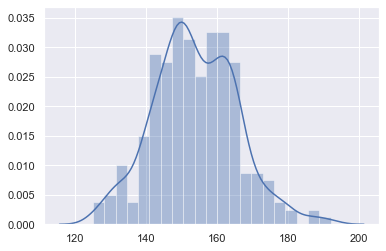

In [18]:
#Plot number of barcodes that go from 0 to 1 due to template switching (and thresholding)
sns.distplot(templateadded)
print("Average number of barcodes gained from template switching and thresholding:", np.mean(templateadded))

Average net change in number of barcodes: 112.476


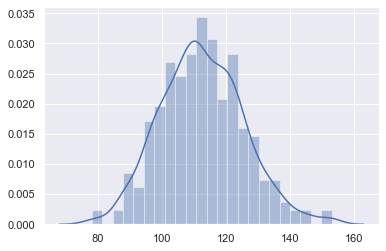

In [19]:
#Plot net number of changes in barcodes
sns.distplot(netchange)
print("Average net change in number of barcodes:", np.mean(netchange))

Average FPP: 0.0002032323232323232


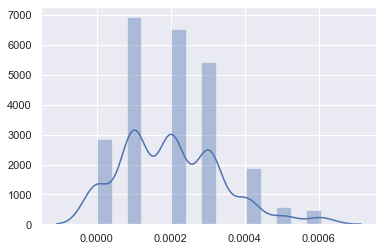

In [20]:
#Plot false positive probabilities
sns.distplot(FPPs) #, kde=False)
print("Average FPP:", np.mean(FPPs))

Average FNP: 0.00035999999999999997


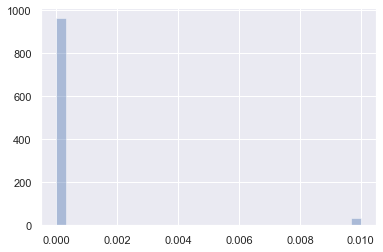

In [21]:
#Plot false negative probabilities
sns.distplot(FNPs, kde=False)
print("Average FNP:", np.mean(FNPs))

# Key Results (10,000 samples per sub-batch, 100,000 samples per run)

In [22]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, scheme 1
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 100, 100, 1, 1, True, 3, 0, 0.05, 0.02, 1, 1, 1, 1)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 5.032
Average number of barcodes gained from template switching: 74.7834
Average net change in number of barcodes: 69.7514
Average FPP: 0.007549272727272728
Average FNP: 0.049864000000000006


In [23]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 4, k1 = 5, scheme 3, k12prime = 3
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 96, 96, 5, 1, True, 4, 0, 0.05, 0.02, 3, 3, 1, 3)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 24.0376
Average number of barcodes gained from template switching: 109.4708
Average net change in number of barcodes: 85.4332
Average FPP: 0.005957939393939394
Average FNP: 0.0008080000000000002


In [24]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 2, k1prime = k2prime = 2
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 96, 96, 3, 3, True, 5, 0, 0.05, 0.02, 2, 2, 2, 4)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 42.15
Average number of barcodes gained from template switching: 152.574
Average net change in number of barcodes: 110.424
Average FPP: 0.004161414141414141
Average FNP: 0.00016800000000000002


In [25]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 6
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 96, 96, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 42.1466
Average number of barcodes gained from template switching: 152.576
Average net change in number of barcodes: 110.4294
Average FPP: 0.00019575757575757575
Average FNP: 0.00044800000000000005


In [26]:
#10,000 samples, 1% positive, 192 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 5
#5,000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 192, 192, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.045
Average number of barcodes gained from template switching: 446.6222
Average net change in number of barcodes: 401.5772
Average FPP: 2.0626262626262624e-05
Average FNP: 0.00010400000000000001


In [27]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 5
#5,000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(5000, 10000, 100, 384, 384, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.7176
Average number of barcodes gained from template switching: 854.6558
Average net change in number of barcodes: 808.9382
Average FPP: 4.0404040404040405e-07
Average FNP: 0.00010400000000000001


# Key Results (100,000 samples per sub-batch, 1,000,000 samples per run)

In [28]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 6
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(500, 100000, 1000, 192, 192, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 354.064
Average number of barcodes gained from template switching: 585.288
Average net change in number of barcodes: 231.224
Average FPP: 0.006335595959595959
Average FNP: 0.000232


In [29]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 6
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 423.856
Average number of barcodes gained from template switching: 2792.432
Average net change in number of barcodes: 2368.576
Average FPP: 1.907070707070707e-05
Average FNP: 0.000344


In [30]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, k1 = k2 = 3, scheme 3, k12prime = 5
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02
simulated = calculateerrorsparallel(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 0.02, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 423.856
Average number of barcodes gained from template switching: 2792.432
Average net change in number of barcodes: 2368.576
Average FPP: 0.00027886868686868686
Average FNP: 1.6e-05


# Key Results (Continuous)

In [31]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Amp, ampmean = 4.5, ampstd = 3, k1 = k2 = 3, scheme 3, k12prime = 6
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 96, 96, 3, 3, True, 5, 0, 0.05, 'Amp', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 42.0526
Average number of barcodes gained from template switching and thresholding: -202.0554
Average net change in number of barcodes: -244.108
Average FPP: 3.905050505050505e-05
Average FNP: 0.31881


In [32]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Sat, satmean = 10000, satstd = 1000, k1 = k2 = 3, scheme 3, k12prime = 6
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 96, 96, 3, 3, True, 5, 0, 0.05, 'Sat', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 42.0466
Average number of barcodes gained from template switching and thresholding: 141.0968
Average net change in number of barcodes: 99.0502
Average FPP: 0.00020456565656565653
Average FNP: 0.000424


In [33]:
#10,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp, ampmean = 4.5, ampstd = 3, k1 = k2 = 3, scheme 3, k12prime = 5
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 192, 192, 3, 3, True, 5, 0, 0.05, 'Amp', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.03
Average number of barcodes gained from template switching and thresholding: -165.8554
Average net change in number of barcodes: -210.8854
Average FPP: 3.1515151515151517e-06
Average FNP: 0.31814000000000003


In [34]:
#10,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Sat, satmean = 10000, satstd = 1000, k1 = k2 = 3, scheme 3, k12prime = 5
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 192, 192, 3, 3, True, 5, 0, 0.05, 'Sat', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.0276
Average number of barcodes gained from template switching and thresholding: 436.9368
Average net change in number of barcodes: 391.9092
Average FPP: 2.1636363636363636e-05
Average FNP: 8e-05


In [35]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp, ampmean = 4.5, ampstd = 3, k1 = k2 = 3, scheme 3, k12prime = 5
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 384, 384, 3, 3, True, 5, 0, 0.05, 'Amp', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.7876
Average number of barcodes gained from template switching and thresholding: -132.513
Average net change in number of barcodes: -178.3006
Average FPP: 8.08080808080808e-08
Average FNP: 0.317804


In [36]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat, satmean = 10000, satstd = 1000, k1 = k2 = 3, scheme 3, k12prime = 5
#5000 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(5000, 10000, 100, 384, 384, 3, 3, True, 5, 0, 0.05, 'Sat', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 45.7896
Average number of barcodes gained from template switching and thresholding: 933.445
Average net change in number of barcodes: 887.6554
Average FPP: 4.0404040404040405e-07
Average FNP: 9.6e-05


In [37]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp, ampmean = 4.5, ampstd = 3, k1 = k2 = 3, scheme 3, k12prime = 6
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 'Amp', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 424.44
Average number of barcodes gained from template switching and thresholding: -4936.608
Average net change in number of barcodes: -5361.048
Average FPP: 0.0
Average FNP: 0.665584


In [38]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat, satmean = 10000, satstd = 1000, k1 = k2 = 3, scheme 3, k12prime = 6
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 200
simulated = calculateerrorsparallelcontinuous(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 'Sat', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 6)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 424.572
Average number of barcodes gained from template switching and thresholding: 2060.78
Average net change in number of barcodes: 1636.208
Average FPP: 1.4626262626262626e-05
Average FNP: 0.00042


In [39]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp, ampmean = 4.5, ampstd = 3, k1 = k2 = 3, scheme 3, k12prime = 5
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 'Amp', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))


Average number of barcodes lost: 424.44
Average number of barcodes gained from template switching and thresholding: -4936.608
Average net change in number of barcodes: -5361.048
Average FPP: 2.9090909090909093e-06
Average FNP: 0.665392


In [102]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat, satmean = 10000, satstd = 1000, k1 = k2 = 3, scheme 3, k12prime = 5
#500 iterations, dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
simulated = calculateerrorsparallelcontinuous(500, 100000, 1000, 384, 384, 3, 3, True, 5, 0, 0.05, 'Sat', 4.5, 3, 10000, 1000, 0.02, 18000000, 100, 3, 3, 2, 5)

print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average number of barcodes gained from template switching and thresholding:", np.mean(simulated[1]))
print("Average net change in number of barcodes:", np.mean(np.mean(simulated[2])))
print("Average FPP:", np.mean(simulated[3]))
print("Average FNP:", np.mean(simulated[4]))

Average number of barcodes lost: 422.944
Average number of barcodes gained from template switching and thresholding: 2066.768
Average net change in number of barcodes: 1643.824
Average FPP: 0.00024686868686868684
Average FNP: 0.0


# Results from Individual Modules (Discrete)

## Module 1 Results (Discrete)

In [24]:
#Helper function to show saturation of barcode matrix
#Assumption that dsynth = 0, dstoch = 0.05
#Left plot is barcode truth, right plot is barcodes with dstoch errors

def module1test(b2, n, m1, m2, k1, k2, scenario, EnforceUnique):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05)
    #Plot figure for visual examination of saturation
    fig_dims = (8, 4)
    fig, axs = plt.subplots(ncols=2, figsize = fig_dims)
    sns.heatmap(barcodetruth, ax=axs[0])
    sns.heatmap(barcodes, ax=axs[1])

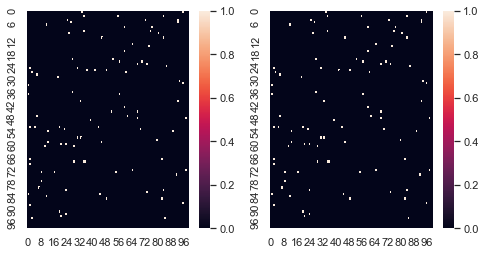

In [25]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3
module1test(10000, 100, 100, 100, 1, 1, 3, True)

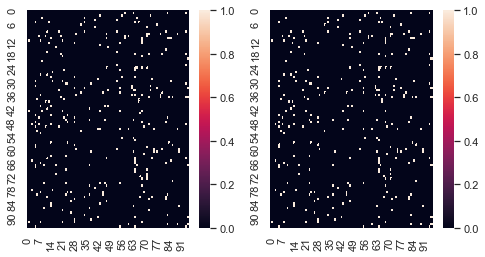

In [26]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 3, scenario 4
module1test(10000, 100, 96, 96, 3, 1, 4, True)

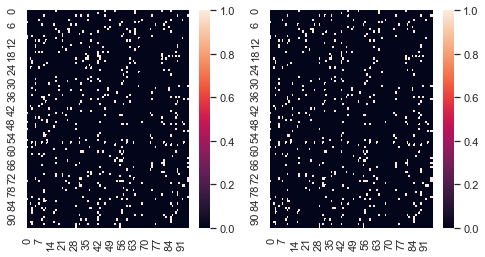

In [27]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4
module1test(10000, 100, 96, 96, 5, 1, 4, True)

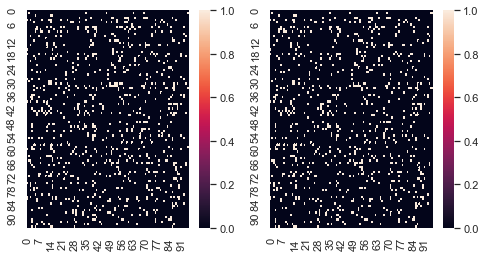

In [28]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(10000, 100, 96, 96, 3, 3, 5, True)

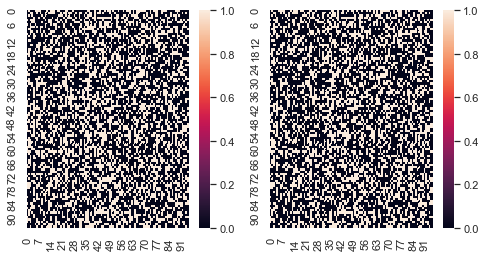

In [29]:
#100,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4
module1test(100000, 1000, 96, 96, 5, 1, 4, True)

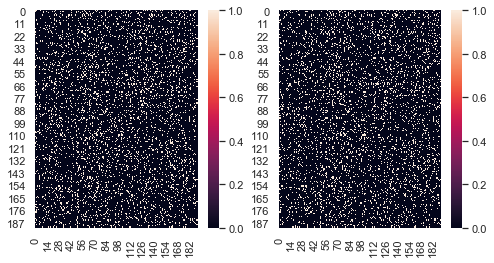

In [30]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = 5, scenario 4
module1test(100000, 1000, 192, 192, 5, 1, 4, True)

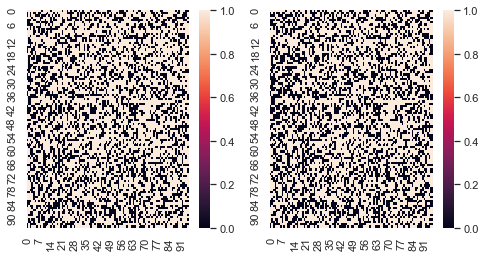

In [31]:
#100,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(100000, 1000, 96, 96, 3, 3, 5, True)

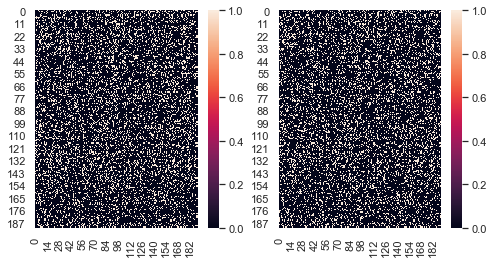

In [32]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(100000, 1000, 192, 192, 3, 3, 5, True)

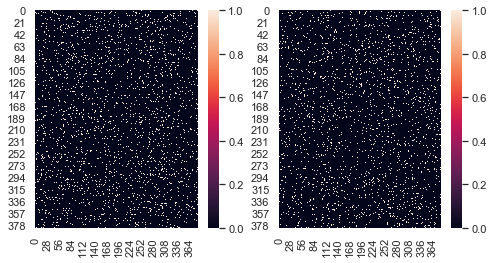

In [33]:
#100,000 samples, 1% positive, 384 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(100000, 1000, 384, 384, 3, 3, 5, True)

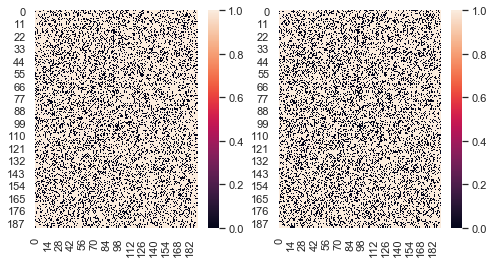

In [34]:
#1,000,000 samples, 1% positive, 192 BC1/BC2, k1 = 5, scenario 4
module1test(1000000, 10000, 192, 192, 5, 1, 4, True)

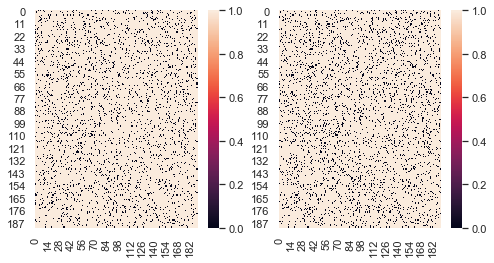

In [35]:
#1,000,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(1000000, 10000, 192, 192, 3, 3, 5, True)

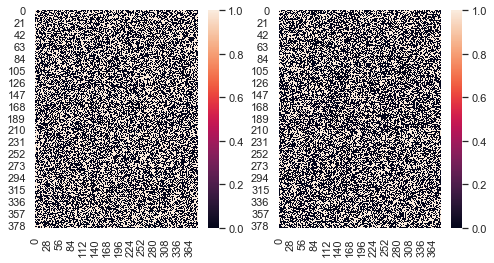

In [36]:
#1,000,000 samples, 1% positive, 384 BC1/BC2, k1 = k2 = 3, scenario 5
module1test(1000000, 10000, 384, 384, 3, 3, 5, True)

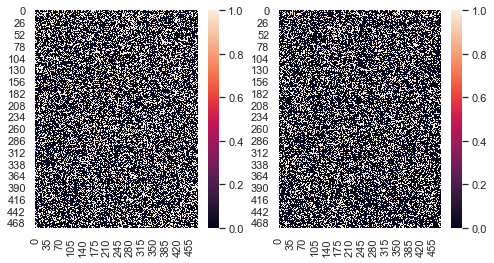

In [37]:
#1,000,000 samples, 1% positive,  BC1/BC2, k1 = k2 = 3, scenario 5
module1test(1000000, 10000, 480, 480, 3, 3, 5, True)

## Module 2 Results (Discrete)

In [38]:
#Helper function to show changes in barcode number due to barcode loss and template switching
#Assumption that dsynth = 0, dstoch = 0.05, dswitch = 0.02
#Left is barcode truth, middle is barcodes with dstoch errors, right is barcodes after template switching

def module2test(b2, n, m1, m2, k1, k2, scenario, EnforceUnique):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05)
    apparentbarcodes = module2discreteencoder(barcodes, 0.02)
    #Plot figure for visual examination of saturation
    fig_dims = (12, 4)
    fig, axs = plt.subplots(ncols=3, figsize = fig_dims)
    sns.heatmap(barcodetruth, ax=axs[0])
    sns.heatmap(barcodes, ax=axs[1])
    sns.heatmap(apparentbarcodes, ax=axs[2])
    #Print barcode changes
    print("Barcodes lost from errors:", np.sum(barcodetruth-barcodes))
    print("Barcodes gained from template switching:", np.sum(apparentbarcodes-barcodes))
    print("Net change in number of barcodes:", np.sum(apparentbarcodes-barcodetruth))

Barcodes lost from errors: 6
Barcodes gained from template switching: 69
Net change in number of barcodes: 63


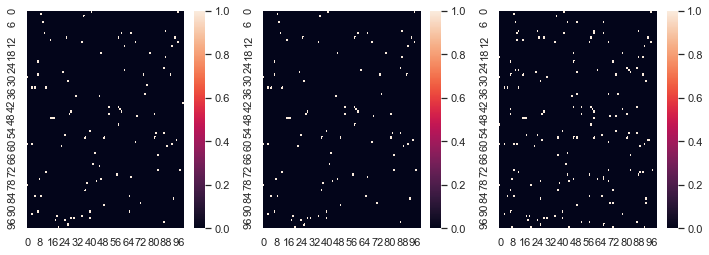

In [39]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3
module2test(10000, 100, 100, 100, 1, 1, 3, True)

Barcodes lost from errors: 23
Barcodes gained from template switching: 98
Net change in number of barcodes: 75


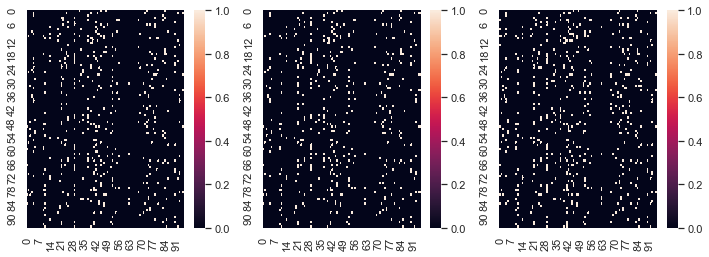

In [40]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4
module2test(10000, 100, 96, 96, 5, 1, 4, True)

Barcodes lost from errors: 42
Barcodes gained from template switching: 153
Net change in number of barcodes: 111


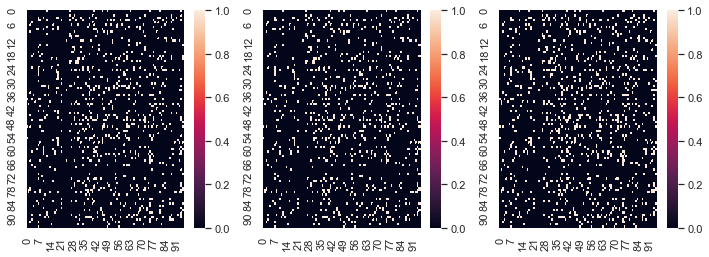

In [41]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5
module2test(10000, 100, 96, 96, 3, 3, 5, True)

Barcodes lost from errors: 226
Barcodes gained from template switching: 638
Net change in number of barcodes: 412


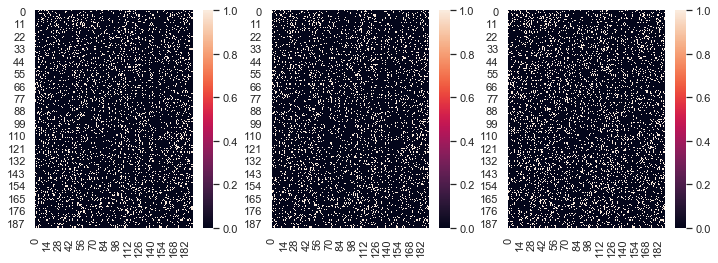

In [42]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = 5, scenario 4
module2test(100000, 1000, 192, 192, 5, 1, 4, True)

Barcodes lost from errors: 337
Barcodes gained from template switching: 582
Net change in number of barcodes: 245


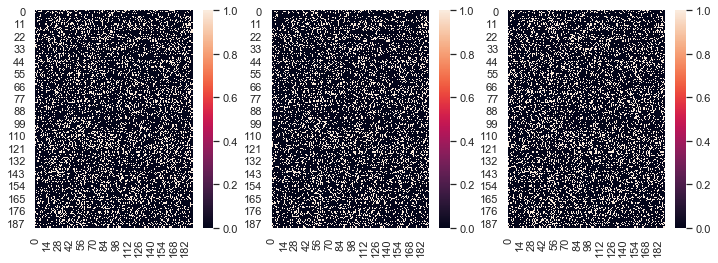

In [43]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5
module2test(100000, 1000, 192, 192, 3, 3, 5, True)

## Module 4 Results (Discrete, Single Iteration)

In [44]:
#Helper function for quick estimates of overall error rates given a certain choice of parameters
#Assumption that dsynth = 0, dstoch = 0.05, dswitch = 0.02

def module4test(b2, n, m1, m2, k1, k2, scenario, EnforceUnique, k1prime, k2prime, k12prime, scheme):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05)
    apparentbarcodes = module2discreteencoder(barcodes, 0.02)
    #Decode apparentbarcodesmatrix, calculate apparent FPP and FNP
    inferredtruth = decoder(apparentbarcodes, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
    #Print barcode changes
    print("Barcodes lost from errors:", np.sum(barcodetruth-barcodes))
    print("Barcodes gained from template switching:", np.sum(apparentbarcodes-barcodes))
    print("Net change in number of barcodes:", np.sum(apparentbarcodes-barcodetruth))
    #Print FPP and FNP
    print("FPP = ", FPP)
    print("FNP = ", FNP)

In [45]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, scheme 1
module4test(10000, 100, 100, 100, 1, 1, 3, True, 1, 1, 1, 1)

Barcodes lost from errors: 5
Barcodes gained from template switching: 75
Net change in number of barcodes: 70
FPP =  0.007474747474747475
FNP =  0.04


In [46]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4, scheme 1
module4test(10000, 100, 96, 96, 5, 1, 4, True, 1, 1, 1, 1)

Barcodes lost from errors: 22
Barcodes gained from template switching: 114
Net change in number of barcodes: 92
FPP =  0.0
FNP =  0.19


In [47]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4, scheme 3, k12prime = 4
module4test(10000, 100, 96, 96, 5, 1, 4, True, 1, 1, 4, 3)

Barcodes lost from errors: 14
Barcodes gained from template switching: 118
Net change in number of barcodes: 104
FPP =  0.000505050505050505
FNP =  0.0


In [48]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 5, scenario 4, scheme 3, k12prime = 3
module4test(10000, 100, 96, 96, 5, 1, 4, True, 1, 1, 3, 3)

Barcodes lost from errors: 29
Barcodes gained from template switching: 123
Net change in number of barcodes: 94
FPP =  0.00595959595959596
FNP =  0.01


In [49]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = 3, scenario 4, scheme 3, k12prime = 2
module4test(10000, 100, 96, 96, 3, 1, 4, True, 1, 1, 2, 3)

Barcodes lost from errors: 17
Barcodes gained from template switching: 115
Net change in number of barcodes: 98
FPP =  0.007272727272727273
FNP =  0.0


In [50]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 1
module4test(10000, 100, 96, 96, 3, 3, 5, True, 3, 3, 9, 1)

Barcodes lost from errors: 39
Barcodes gained from template switching: 136
Net change in number of barcodes: 97
FPP =  0.0
FNP =  0.33


In [51]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 2, k1prime = 2, k2prime = 3
module4test(10000, 100, 96, 96, 3, 3, 5, True, 2, 3, 9, 2)

Barcodes lost from errors: 50
Barcodes gained from template switching: 158
Net change in number of barcodes: 108
FPP =  0.00010101010101010101
FNP =  0.01


In [52]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 2, k1prime = 2, k2prime = 2
module4test(10000, 100, 96, 96, 3, 3, 5, True, 2, 2, 9, 2)

Barcodes lost from errors: 38
Barcodes gained from template switching: 156
Net change in number of barcodes: 118
FPP =  0.004343434343434344
FNP =  0.0


In [53]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 6
module4test(10000, 100, 96, 96, 3, 3, 5, True, 2, 2, 6, 3)

Barcodes lost from errors: 24
Barcodes gained from template switching: 134
Net change in number of barcodes: 110
FPP =  0.00030303030303030303
FNP =  0.0


In [54]:
#10,000 samples, 1% positive, 96 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 7
module4test(10000, 100, 96, 96, 3, 3, 5, True, 2, 2, 7, 3)

Barcodes lost from errors: 49
Barcodes gained from template switching: 150
Net change in number of barcodes: 101
FPP =  0.0
FNP =  0.01


In [55]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = 5, scenario 4, scheme 3, k12prime = 3
module4test(100000, 1000, 192, 192, 5, 1, 4, True, 5, 1, 3, 3)

Barcodes lost from errors: 230
Barcodes gained from template switching: 681
Net change in number of barcodes: 451
FPP =  0.025161616161616163
FNP =  0.001


In [56]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = 5, scenario 4, scheme 3, k12prime = 4
module4test(100000, 1000, 192, 192, 5, 1, 4, True, 5, 1, 4, 3)

Barcodes lost from errors: 233
Barcodes gained from template switching: 648
Net change in number of barcodes: 415
FPP =  0.0025555555555555557
FNP =  0.017


In [57]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 5
module4test(100000, 1000, 192, 192, 3, 3, 5, True, 2, 2, 5, 3)

Barcodes lost from errors: 344
Barcodes gained from template switching: 598
Net change in number of barcodes: 254
FPP =  0.033666666666666664
FNP =  0.0


In [58]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 6
module4test(100000, 1000, 192, 192, 3, 3, 5, True, 2, 2, 6, 3)

Barcodes lost from errors: 364
Barcodes gained from template switching: 620
Net change in number of barcodes: 256
FPP =  0.006666666666666667
FNP =  0.0


In [59]:
#100,000 samples, 1% positive, 192 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 7
module4test(100000, 1000, 192, 192, 3, 3, 5, True, 2, 2, 7, 3)

Barcodes lost from errors: 331
Barcodes gained from template switching: 563
Net change in number of barcodes: 232
FPP =  0.0008282828282828282
FNP =  0.002


In [60]:
#100,000 samples, 1% positive, 384 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 6
module4test(100000, 1000, 384, 384, 3, 3, 5, True, 2, 2, 6, 3)

Barcodes lost from errors: 442
Barcodes gained from template switching: 2742
Net change in number of barcodes: 2300
FPP =  2.0202020202020203e-05
FNP =  0.0


In [61]:
#100,000 samples, 1% positive, 384 BC1/BC2, k1 = k2 = 3, scenario 5, scheme 3, k12prime = 5
module4test(100000, 1000, 384, 384, 3, 3, 5, True, 2, 2, 5, 3)

Barcodes lost from errors: 399
Barcodes gained from template switching: 2802
Net change in number of barcodes: 2403
FPP =  0.0003131313131313131
FNP =  0.001


# Results from Individual Modules (Continuous)

## Module 1 Results (Continuous)

In [62]:
#Helper function to show saturation of barcode matrix
#Assumption that dsynth = 0, dstoch = 0.05
#Left plot is barcode truth, right plot is barcodes with dstoch errors

def module1continuoustest(b2, n, m1, m2, k1, k2, scenario, EnforceUnique, setting, ampmean, ampstd, satmean, satstd):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = continuouslossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05, setting, ampmean, ampstd, satmean, satstd)
    #Plot figure for visual examination of saturation
    fig_dims = (8, 4)
    fig, axs = plt.subplots(ncols=2, figsize = fig_dims)
    sns.heatmap(barcodetruth, ax=axs[0])
    sns.heatmap(barcodes, ax=axs[1])

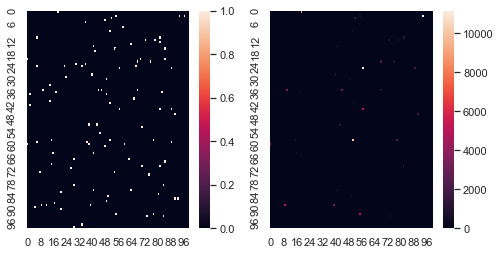

In [63]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Amp
module1continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Amp", ampmean, ampstd, satmean, satstd)

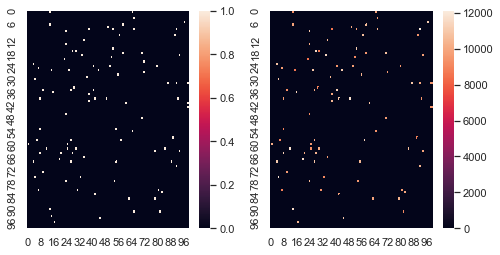

In [64]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Sat
module1continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Sat", ampmean, ampstd, satmean, satstd)

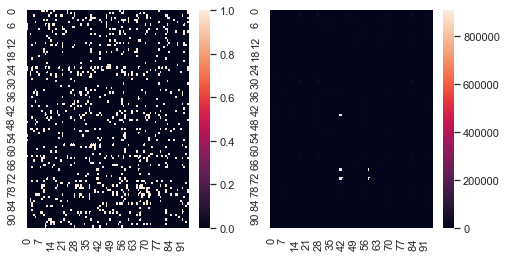

In [65]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Amp
module1continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Amp", ampmean, ampstd, satmean, satstd)

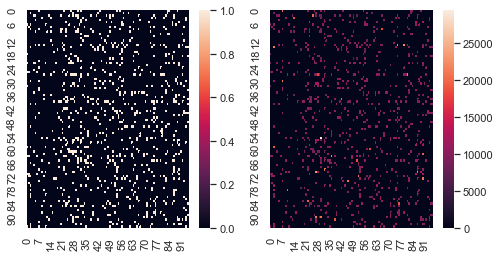

In [66]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Sat
module1continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Sat", ampmean, ampstd, satmean, satstd)

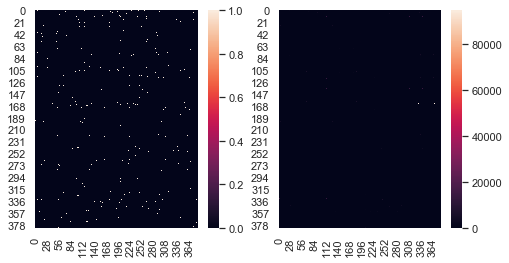

In [67]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp
module1continuoustest(10000, 100, 384, 384, 3, 3, 5, True, "Amp", ampmean, ampstd, satmean, satstd)

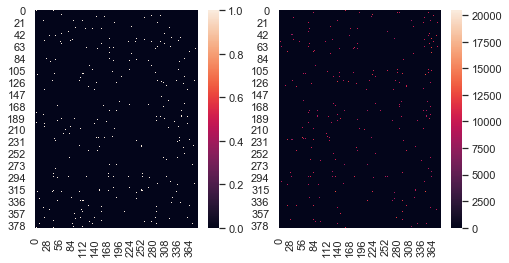

In [68]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat
module1continuoustest(10000, 100, 384, 384, 3, 3, 5, True, "Sat", ampmean, ampstd, satmean, satstd)

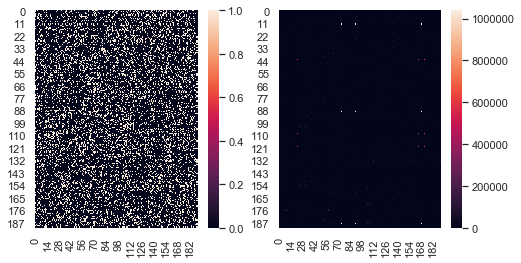

In [69]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp
module1continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Amp", ampmean, ampstd, satmean, satstd)

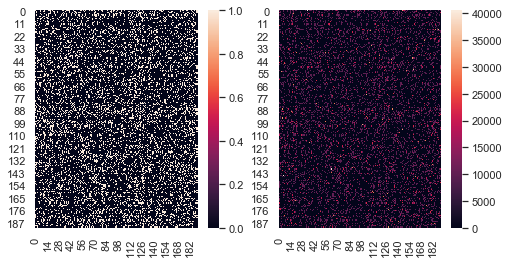

In [70]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Sat
module1continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Sat", ampmean, ampstd, satmean, satstd)

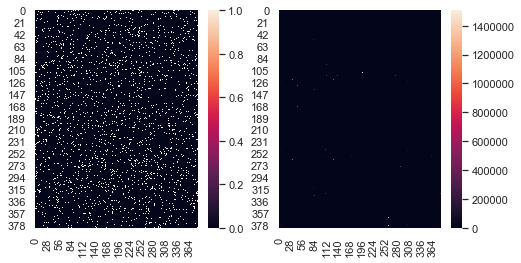

In [71]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp
module1continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Amp", ampmean, ampstd, satmean, satstd)

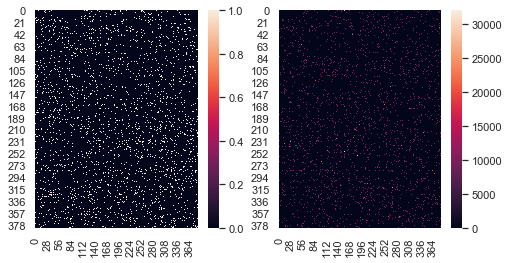

In [72]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat
module1continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Sat", ampmean, ampstd, satmean, satstd)

## Module 2 and 3 Results (Continuous)

In [73]:
#Helper function to show changes in barcode number due to barcode loss and template switching after thresholding
#Assumption that dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
#Also, ampmean = 4.5, ampstd = 3, satmean = 10000, satstd = 1000
#Left is barcode truth, middle left is barcodes with dstoch errors and skewing
#Middle right is barcodes after template switching, right is barcodes after thresholding

def module2and3continuoustest(b2, n, m1, m2, k1, k2, scenario, EnforceUnique, setting, ampmean, ampstd, satmean, satstd, goodreads, threshold):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = continuouslossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05, setting, ampmean, ampstd, satmean, satstd)
    apparentbarcodes = module2continuousencoder(barcodes, 0.02)
    barcodesthresholded = module3continuousencoder(apparentbarcodes, goodreads, threshold)
    #Plot figure for visual examination of saturation
    fig_dims = (18, 4)
    fig, axs = plt.subplots(ncols=4, figsize = fig_dims)
    sns.heatmap(barcodetruth, ax=axs[0])
    sns.heatmap(barcodes, ax=axs[1])
    sns.heatmap(apparentbarcodes, ax=axs[2])
    sns.heatmap(barcodesthresholded, ax=axs[3])
    #Discretize for barcode counting
    barcodes = np.where(barcodes > 0, 1, 0).astype(int)
    #Print barcode changes
    print("Barcodes lost from errors:", np.sum(barcodetruth-barcodes))
    print("Barcodes gained from template switching and thresholding:", np.sum(barcodesthresholded-barcodes))
    print("Net change in number of barcodes:", np.sum(barcodesthresholded-barcodetruth))

Barcodes lost from errors: 7
Barcodes gained from template switching and thresholding: -1
Net change in number of barcodes: -8


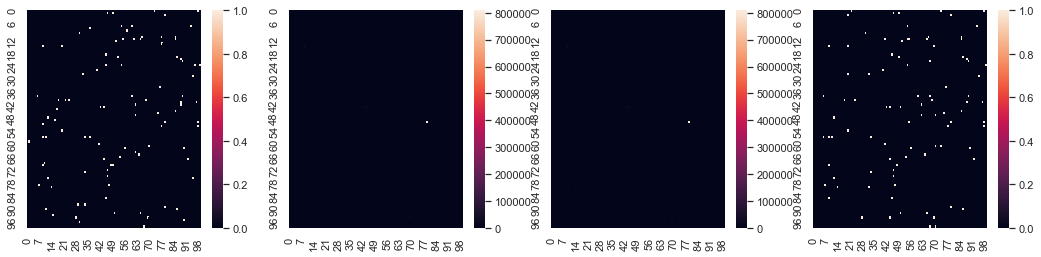

In [74]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Amp
module2and3continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 6
Barcodes gained from template switching and thresholding: 81
Net change in number of barcodes: 75


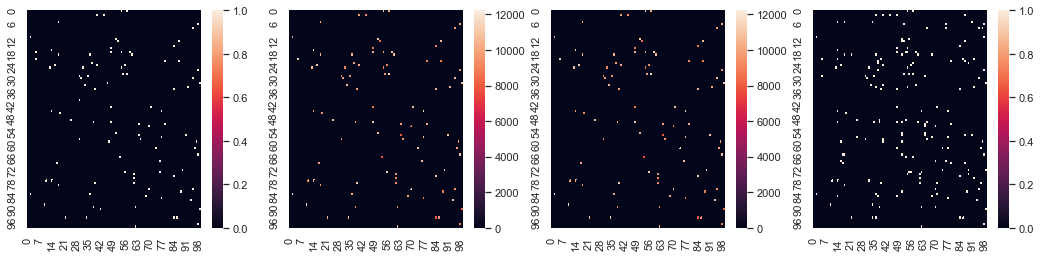

In [75]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Sat
module2and3continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 43
Barcodes gained from template switching and thresholding: -96
Net change in number of barcodes: -139


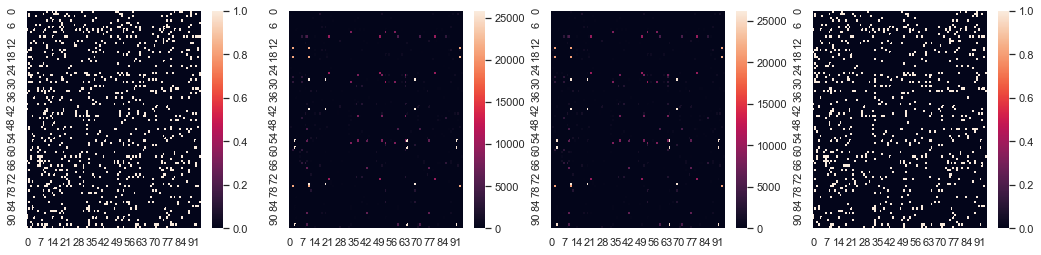

In [76]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Amp
module2and3continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 41
Barcodes gained from template switching and thresholding: 136
Net change in number of barcodes: 95


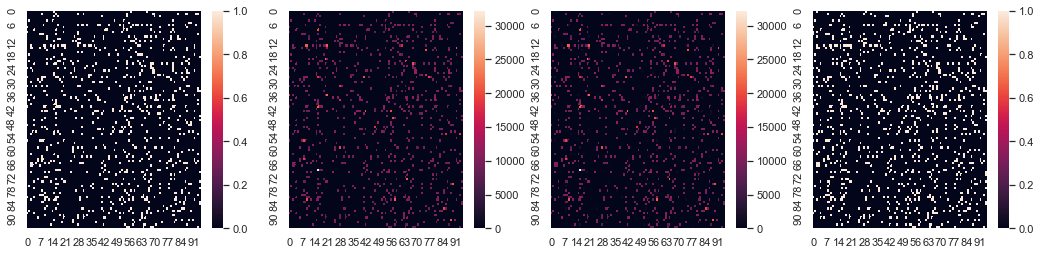

In [77]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Sat
module2and3continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 50
Barcodes gained from template switching and thresholding: -28
Net change in number of barcodes: -78


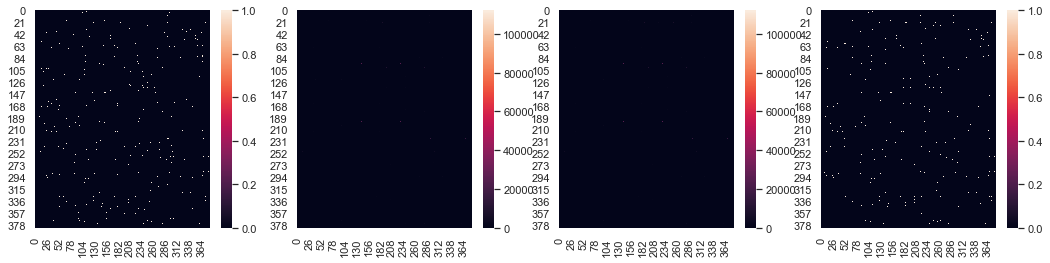

In [78]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp
module2and3continuoustest(10000, 100, 384, 384, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 49
Barcodes gained from template switching and thresholding: 937
Net change in number of barcodes: 888


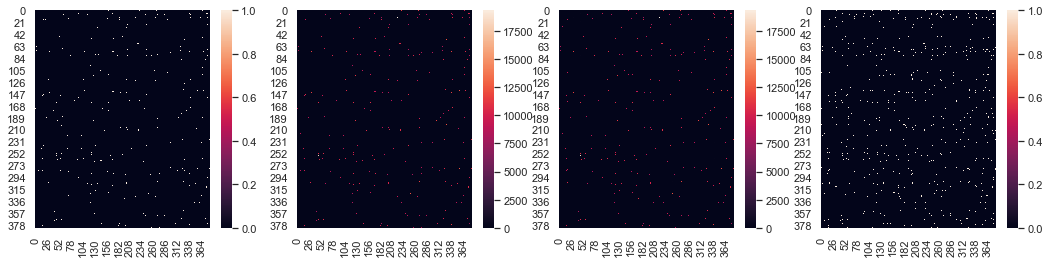

In [79]:
#10,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat
module2and3continuoustest(10000, 100, 384, 384, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 376
Barcodes gained from template switching and thresholding: -5626
Net change in number of barcodes: -6002


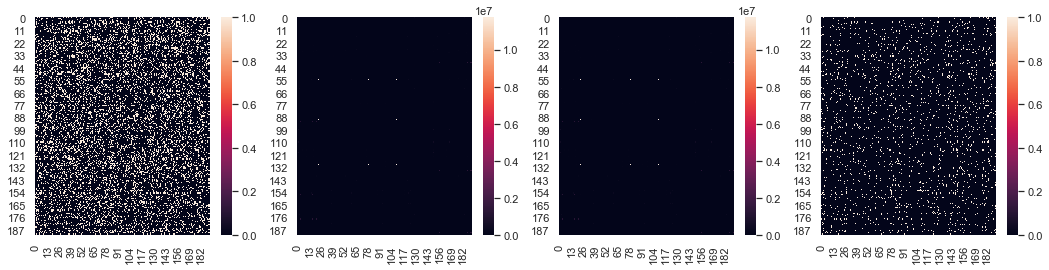

In [80]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp
module2and3continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 351
Barcodes gained from template switching and thresholding: 580
Net change in number of barcodes: 229


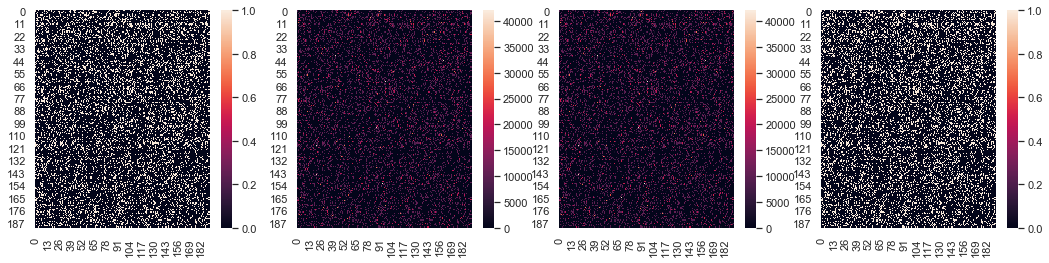

In [81]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Sat
module2and3continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 396
Barcodes gained from template switching and thresholding: -4597
Net change in number of barcodes: -4993


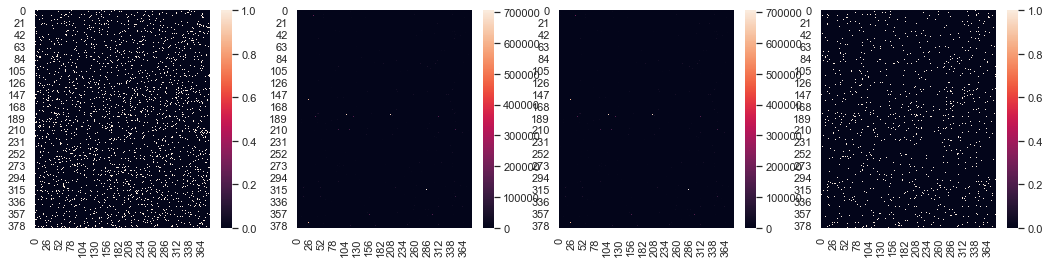

In [82]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp
module2and3continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100)

Barcodes lost from errors: 427
Barcodes gained from template switching and thresholding: 2070
Net change in number of barcodes: 1643


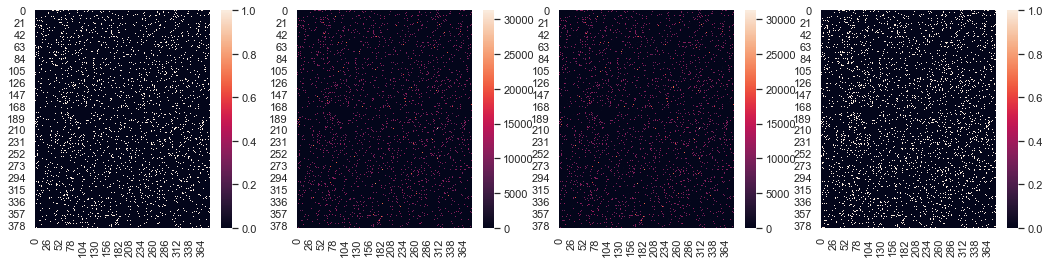

In [83]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Sat
module2and3continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100)

## Module 4 Results (Continuous)

In [84]:
#Helper function for quick estimates of overall error rates given a certain choice of parameters
#Assumption that dsynth = 0, dstoch = 0.05, dswitch = 0.02, goodreads = 18000000, threshold = 100
#Also, ampmean = 4.5, ampstd = 3, satmean = 10000, satstd = 1000

def module4continuoustest(b2, n, m1, m2, k1, k2, scenario, EnforceUnique, setting, ampmean, ampstd, satmean, satstd, goodreads, threshold, k1prime, k2prime, k12prime, scheme):
    #Generate ground truth of patient samples
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])
    #Encode barcodes from ground truth array
    barcodetruth = discretelossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0)
    barcodes = continuouslossyencoder(groundtruth, m1, m2, k1, k2, EnforceUnique, scenario, 0, 0.05, setting, ampmean, ampstd, satmean, satstd)
    apparentbarcodes = module2continuousencoder(barcodes, 0.02)
    barcodesthresholded = module3continuousencoder(apparentbarcodes, goodreads, threshold)
    #Decode apparentbarcodesmatrix, calculate apparent FPP and FNP
    inferredtruth = decoder(barcodesthresholded, b2, k1, k2, EnforceUnique, scheme, k1prime, k2prime, k12prime, scenario)
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredtruth)
    #Discretize for barcode counting
    barcodes = np.where(barcodes > 0, 1, 0).astype(int)
    #Print barcode changes
    print("Barcodes lost from errors:", np.sum(barcodetruth-barcodes))
    print("Barcodes gained from template switching and thresholding:", np.sum(barcodesthresholded-barcodes))
    print("Net change in number of barcodes:", np.sum(barcodesthresholded-barcodetruth))
    #Print FPP and FNP
    print("FPP = ", FPP)
    print("FNP = ", FNP)

In [85]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Amp, scheme 1
module4continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100, 1, 1, 1, 1)

Barcodes lost from errors: 4
Barcodes gained from template switching and thresholding: 23
Net change in number of barcodes: 19
FPP =  0.0029292929292929295
FNP =  0.1


In [86]:
#10,000 samples, 1% positive, 100 BC1/BC2, scenario 3, Amp, scheme 1
module4continuoustest(10000, 100, 100, 100, 1, 1, 3, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 1, 1, 1, 1)

Barcodes lost from errors: 3
Barcodes gained from template switching and thresholding: 90
Net change in number of barcodes: 87
FPP =  0.00909090909090909
FNP =  0.03


In [87]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 6
module4continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 43
Barcodes gained from template switching and thresholding: -143
Net change in number of barcodes: -186
FPP =  0.00010101010101010101
FNP =  0.25


In [88]:
#10,000 samples, 1% positive, 96 BC1/BC2, scenario 5, Sat, scheme 3, k12prime 6
module4continuoustest(10000, 100, 96, 96, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 47
Barcodes gained from template switching and thresholding: 133
Net change in number of barcodes: 86
FPP =  0.00040404040404040404
FNP =  0.01


In [89]:
#10,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 6
module4continuoustest(10000, 100, 192, 192, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 38
Barcodes gained from template switching and thresholding: -207
Net change in number of barcodes: -245
FPP =  0.0
FNP =  0.34


In [90]:
#10,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Sat, scheme 3, k12prime 6
module4continuoustest(10000, 100, 192, 192, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 49
Barcodes gained from template switching and thresholding: 428
Net change in number of barcodes: 379
FPP =  0.0
FNP =  0.0


In [91]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 6
module4continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Amp", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 360
Barcodes gained from template switching and thresholding: -4551
Net change in number of barcodes: -4911
FPP =  3.0303030303030302e-05
FNP =  0.673


In [92]:
#100,000 samples, 1% positive, 192 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 6
module4continuoustest(100000, 1000, 192, 192, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 361
Barcodes gained from template switching and thresholding: 586
Net change in number of barcodes: 225
FPP =  0.0062525252525252525
FNP =  0.0


In [93]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 6
module4continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 6, 3)

Barcodes lost from errors: 412
Barcodes gained from template switching and thresholding: 2020
Net change in number of barcodes: 1608
FPP =  3.0303030303030302e-05
FNP =  0.0


In [94]:
#100,000 samples, 1% positive, 384 BC1/BC2, scenario 5, Amp, scheme 3, k12prime 5
module4continuoustest(100000, 1000, 384, 384, 3, 3, 5, True, "Sat", 4.5, 3, 10000, 1000, 18000000, 100, 2, 3, 5, 3)

Barcodes lost from errors: 431
Barcodes gained from template switching and thresholding: 1990
Net change in number of barcodes: 1559
FPP =  0.0002323232323232323
FNP =  0.0


# Old Models of Continuous Template Switching (Deprecated)

- For continuous, D<sub>switch</sub> proportion of all reads are from template switching. 
    - Template switching reads are proportional to (# of barcode 1 in pool) x (# of barcode 2 in pool)

In [95]:
def module2continuousencoderold(barcodes, dswitch):
    '''
    Function takes np array of counts for each barocde and returns array of counts including template switching
    
    Inputs:
        barcodes - array (m1 x m2), contains reads per barcode
        dswitch - probability of template switching as outlined above
    
    Outputs:
        apparentbarcodes - array (m1 x m2), contains reads per barcode
    '''
    #Initialize array
    (m1, m2) = barcodes.shape
    apparentbarcodes = np.zeros((m1, m2))
    
    #Compute barcodes in positive PCR pool
    positiveBC1s = np.sum(barcodes, axis=1)
    positiveBC1indices = np.where(positiveBC1s > 0)[0]

    positiveBC2s = np.sum(barcodes, axis=0)
    positiveBC2indices = np.where(positiveBC2s > 0)[0]
    
    #Add reads to template switching edges
    for BC1index in positiveBC1indices:
        for BC2index in positiveBC2indices:
            apparentbarcodes[BC1index, BC2index] = positiveBC1s[BC1index]*positiveBC2s[BC2index]

    #Make Dswitch proportion of reads due to template switching
    apparentbarcodes = (1-dswitch)/np.sum(barcodes)*barcodes + dswitch/np.sum(apparentbarcodes)*apparentbarcodes
    
    #Return final array                                
    return apparentbarcodes

- For continuous, D<sub>switch</sub> proportion of the time a template switching read is added
    - Template switching reads added are average of reads for barcode 1 * average of reads for barcode 2

In [96]:
def module2continuousencoderold2(barcodes, dswitch):
    '''
    Function takes np array of counts for each barocde and returns array of counts including template switching
    
    Inputs:
        barcodes - array (m1 x m2), contains reads per barcode
        dswitch - probability of template switching as outlined above
    
    Outputs:
        apparentbarcodes - array (m1 x m2), contains reads per barcode
    '''
    #Initialize array
    (m1, m2) = barcodes.shape
    apparentbarcodes = barcodes.copy()
    
    #Compute barcodes in positive PCR pool
    positiveBC1s = np.sum(barcodes, axis=1)
    positiveBC1indices = np.where(positiveBC1s > 0)[0]

    positiveBC2s = np.sum(barcodes, axis=0)
    positiveBC2indices = np.where(positiveBC2s > 0)[0]
    
    #Add reads to template switching edges
    for BC1index in positiveBC1indices:
        for BC2index in positiveBC2indices:
            
            #If RNG < thresholdprob, add molecules that are average for barcodes
            randomprob = random.random()
            if randomprob <= dswitch: #Flips thresholdprob proportion of the time
                apparentbarcodes[BC1index, BC2index] += (positiveBC1s[BC1index]/m1+positiveBC2s[BC2index]/m2)/2
    
    #Return final array                                
    return apparentbarcodes

- For continuous, proportion of the time a template switching read is added is read number dependent
    - Calculated as probability = D<sub>switch</sub>* relative abundance BC1 * relative abundance BC2 (thresholded at 1)
    - Template switching reads added are average of reads for barcode 1 * average of reads for barcode 2

In [97]:
def module2continuousencoderold3(barcodes, dswitch):
    '''
    Function takes np array of counts for each barocde and returns array of counts including template switching
    
    Inputs:
        barcodes - array (m1 x m2), contains reads per barcode
        dswitch - probability of template switching as outlined above
    
    Outputs:
        apparentbarcodes - array (m1 x m2), contains reads per barcode
    '''
    #Initialize array
    (m1, m2) = barcodes.shape
    apparentbarcodes = barcodes.copy()
    
    #Compute barcodes in positive PCR pool
    positiveBC1s = np.sum(barcodes, axis=1)
    positiveBC1indices = np.where(positiveBC1s > 0)[0]

    positiveBC2s = np.sum(barcodes, axis=0)
    positiveBC2indices = np.where(positiveBC2s > 0)[0]
    
    #Add reads to template switching edges
    for BC1index in positiveBC1indices:
        for BC2index in positiveBC2indices:
            #Compute propensity/threshold probability for template switching
            BC1propensity = positiveBC1s[BC1index]/np.mean(positiveBC1s!=0) #Relative abundance compared to average                  
            BC2propensity = positiveBC2s[BC2index]/np.mean(positiveBC2s!=0) #Relative abundance compared to average
            thresholdprob = min(dswitch*BC1propensity*BC2propensity, 1)
            
            #If RNG < thresholdprob, add molecules that are average for barcodes
            randomprob = random.random()
            if randomprob <= thresholdprob: #Flips thresholdprob proportion of the time
                apparentbarcodes[BC1index, BC2index] += (positiveBC1s[BC1index]/m1+positiveBC2s[BC2index]/m2)/2
    
    #Return final array                                
    return apparentbarcodes